Copyright 2024 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

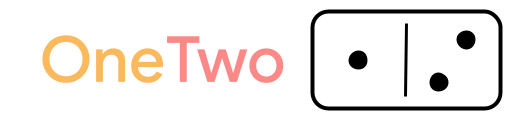

This colab illustrates how to use the [OneTwo](https://github.com/google-deepmind/onetwo) library.



# Setup

## Installation

In [ ]:
# Uncomment the following line and execute the cell to install OneTwo (if not already installed).
# !pip install git+https://github.com/google-deepmind/onetwo

##Imports

In [ ]:
# At minimum, these are the libraries you will need to import to perform basic
# operations with OneTwo.
from onetwo import ot
from onetwo.builtins import llm

In [ ]:
# These are some additional libraries that we will use in certain sections of
# the colab.
from collections.abc import Mapping, Sequence
import copy
import dataclasses
import datetime
import functools
import IPython
import numpy as np
import os
import pandas as pd
import pprint
import re
import textwrap
import typing
from typing import Any, Generic, TypeVar

from google.colab import data_table

from onetwo.agents import python_planning
from onetwo.agents import react
from onetwo.builtins import composables
from onetwo.core import results
from onetwo.core import sampling
from onetwo.core import tracing
from onetwo.core import utils
from onetwo.evaluation import agent_evaluation
from onetwo.stdlib.code_execution import python_execution_safe_subset
from onetwo.stdlib.ensembling import distribution_metrics
from onetwo.stdlib.ensembling import self_consistency
from onetwo.stdlib.reasoning import chain_of_thought
from onetwo.stdlib.tool_use import llm_tool_use
from onetwo.stdlib.tool_use import python_tool_use




In [ ]:
# Display DataFrames by default as interactive tables.
data_table.enable_dataframe_formatter()

# Overview

One of the key principles behind the OneTwo library is to enable the creation of complex flows involving several calls to foundation models and possibly other tools.

We facilitate through functionality at two levels:
* **OneTwo Core:** Low-level libraries for connecting to models, prompting them, and constructing programs that chain multiple calls to such models, while leaving you full flexibility in the structuring of your program (just like if you were programming in pure Python).
* **OneTwo Standard Library:** A set of reusable components built on top of the OneTwo Core, providing generic implementations of a wide range of SOTA prompting strategies from Google DeepMind, Google Research, and published research from outside of Google.

In this overview, we provide a quick introduction to both the OneTwo core and the OneTwo standard library, with the intention that with the overview alone, you should already be up and running with OneTwo in less than an hour. Feel free to then continue on with the advanced sections, or come back to them later!

**OneTwo Core**

For ease of experimentation, it is important to easily change the backends or their configuration and run the same flow on two backends/configurations, e.g. when doing comparisons.

The bottleneck is often the multiple RPC requests that need to happen. This makes fast iterations or experimenting on many examples slow and tedious. In order to reduce this bottleneck, there are two strategies that are implemented in the OneTwo library:
1. **Caching**: The result of the calls to the models are cached, which enables one to very quickly replay a flow or an experiment which may have partially executed (e.g. failed in the middle of execution). For example, if you have a complex flow and want to add just one extra step, rerunning the whole thing amounts to reading everything from cache and only executing for real that one last step.
1. **Asynchronous Execution**: While some of the model calls might need to be chained serially, there are many situations when you may want to execute some calls in parallel (e.g. talking to different backends, running an experiment on many examples, or having a step in your flow where several independent tasks are performed). A natural way to do that is to use asynchronous programming, or multi-threading.

In the first several sub-sections of the overview, we provide an introduction that illustrates how to connect to and prompt a model using the basic OneTwo functionality.

**OneTwo Standard Library:**

In the later sub-sections of the overview, we introduce some of the most widely used components from the OneTwo standard library, including bread-and-butter techniques such as chain-of-thought and self-consistency, as well as more complex agent and tool use strategies.

More details on the OneTwo standard library and other advanced features are provided in additional sections after the overview.

## Connecting to a Model

The Gemini, and OpenAI APIs provide an easy way to connect to a model. Select your preferred API/model in the drop-down and enter the corresponding API key (where relevant) in the text box below.

OneTwo also supports connecting to other models such as Gemma models running locally or on a server. See Appendix A for details.

### Model Selection

In [ ]:
# @title {run:"auto"}

# Select one of the LLM backend options here
model_selection = 'Gemini API' # @param [ 'Gemini API', 'OpenAI API']

# Boilerplate for conditional cell execution
@IPython.core.magic.register_cell_magic('run_if')
def run_if(line, cell):
  if eval(line):
     IPython.get_ipython().run_cell(cell)
  else:
    pass

### Caching Configuration

In [ ]:
# Here we define a location in which to store a cache of requests/replies for
# each backend of interest, which we can use for speeding up running of the
# colab if we re-run it (or make iterative modifications to it) in the future.
# We will use a separate cache file for each backend.
OWN_CACHE_DIRECTORY = '/tmp/onetwo_colab_backend_caches/tutorial'

# If you would like to share cache files with others in your working group, you
# can optionally specify another shared cache directory here. If you specify
# this, then we will read from shared cache directory and give precedence to its
# contents, while merging in any additional content from OWN_CACHE_DIRECTORY.
# When saving the cache, however, we will by default write only to
# OWN_CACHE_DIRECTORY to reduce the chance of people clobbering each other's
# changes.
SHARED_CACHE_DIRECTORY = None

# If you want to automatically merge in content from any of your teammates'
# cache directories or from a cache that was output by a batch eval run,
# you can list the additional directories here.
ADDITIONAL_CACHE_DIRECTORIES = []

### Caching Functions

Here we define some helper functions for loading/saving backend caches.

In [ ]:
def get_model_name_for_cache(model_name: Any, temperature: float = 0.0) -> str:
  """Returns a name to identify the model/temperature for caching."""
  if not isinstance(model_name, str):
    model_name = str(model_name)
  if match := re.search(r'\.(.+)', model_name):
    model_name = match[1]
  if temperature > 0:
    temperature_str = str(temperature).replace('.', '_')
    model_name = f'{model_name}_{temperature_str}'
  return model_name

def get_cache_path(model_name: Any, temperature: float = 0.0) -> str:
  """Returns the path for caching a given model (may be an enum or a string)."""
  model_name_for_cache = get_model_name_for_cache(model_name, temperature)
  return os.path.join(OWN_CACHE_DIRECTORY, f'{model_name_for_cache}.json')

def load_backend_cache(backend: Any, *, overwrite: bool = True):
  """Checks if the cache file(s) already exist, in which case we load them.

  Args:
    backend: The backend for which to load the cache.
    overwrite: If True, then completely replaces the current in-memory cache
      with the contents of the cache file(s). If False, then preserves the
      current in-memory cache contents, while merging in any additional content
      from the file(s).
  """
  if not backend.cache_filename:
    print('No cache filename specified for {backend.model_name}. Not loading.')
    return
  cache_file_basename = os.path.basename(backend.cache_filename)

  cache_filenames = []
  if SHARED_CACHE_DIRECTORY:
    shared_cache_filename = os.path.join(
        SHARED_CACHE_DIRECTORY, cache_file_basename)
    cache_filenames.append(shared_cache_filename)
  if backend.cache_filename and backend.cache_filename not in cache_filenames:
    cache_filenames.append(backend.cache_filename)
  if ADDITIONAL_CACHE_DIRECTORIES:
    for cache_directory in ADDITIONAL_CACHE_DIRECTORIES:
      cache_filename = os.path.join(cache_directory, cache_file_basename)
      if cache_filename not in cache_filenames:
        cache_filenames.append(cache_filename)

  backend_name = cache_file_basename.split('.')[0]
  if cache_filenames:
    print(f'Loading {len(cache_filenames)} cache file(s) for {backend_name}.')
  else:
    print(f'No cache files specified for {backend_name}.')

  for cache_filename in cache_filenames:
    if os.path.exists(cache_filename):
      print(f'Loading cache from {cache_filename} ({overwrite=}).')
      cache_size_before = len(backend._cache_handler._cache_data.values_by_key)
      backend.load_cache(overwrite=overwrite, cache_filename=cache_filename)
      cache_size_after = len(backend._cache_handler._cache_data.values_by_key)
      print(f'Loaded {cache_size_after - cache_size_before} items: '
            f'{cache_size_before} => {cache_size_after}.')
      overwrite = False
    else:
      print(f'Cache file does not exist: {cache_filename}')

def load_backend_caches(backends: Sequence[Any]):
  """Loads the caches of all the given backends."""
  for backend in backends:
    load_backend_cache(backend)

def save_backend_caches(
    backends: Sequence[Any],
    *,
    cache_directory: str | None = None):
  """Saves the caches of all the given backends.

  Args:
    backends: The backends for which to save the caches.
    cache_directory: If specified, then will save the caches to this directory.
      Otherwise, will save the caches to the location configured when the
      backend was created.
  """
  for backend in backends:
    cache_filename = backend.cache_filename
    if cache_directory:
      cache_filename = os.path.join(
          cache_directory, os.path.basename(cache_filename))
    time_string = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'{time_string}: Saving cache to {cache_filename}.')
    backend.save_cache(cache_filename=cache_filename, overwrite=True)

In [ ]:
# We will keep track of all the backends that we construct in this colab (as a
# mapping of name to backend instance), to make it easy to load/save the caches.
# Having a mapping of backends like this can also be convenient when doing
# things constructing an experiment run that does a sweep over multiple LLMs.
backends = {}

### Gemini API

OneTwo can connect to publicly-hosted Gemini models via the Gemini API. If you have not used the Gemini API before, you will need to first create an account and API key following the instructions on https://ai.google.dev/. Then either copy-paste your API key into the text box, or store it in the 'GOOGLE_API_KEY' environment variable.

In [ ]:
%%run_if model_selection == 'Gemini API'  # Execute cell only for 'Gemini API'

from onetwo.backends import gemini_api

# You can specify your API key either here or as an environment variable.
api_key = ""  # @param {type: 'string'}

if not api_key and 'GOOGLE_API_KEY' not in os.environ:
  raise ValueError(
      'The api key must be specified either here or in the environment.')

# Create and register a connection to the default Gemini backend (Gemini Pro).
backend = gemini_api.GeminiAPI(
    api_key=api_key,
    temperature=0.0,
    cache_filename=get_cache_path('GEMINI_PRO', temperature=0.0),
)
backends['GEMINI_PRO'] = backend
backend.register()
print('Gemini API backend registered.')

### OpenAI API

OneTwo can connect to OpenAI models via the OpenAI API. If you have not used the OpenAI API before, you will need to first create an account and API key at https://platform.openai.com/signup. Then copy-paste your API key into the text box below.

In [ ]:
%%run_if model_selection == 'OpenAI API'  # Execute cell only for 'OpenAI API'

from onetwo.backends import openai_api

# You can specify your API key either here or as an environment variable.
api_key = ""  # @param {type: 'string'}

if not api_key and 'OPENAI_API_KEY' not in os.environ:
  raise ValueError(
      'The api key must be specified either here or in the environment.')

model_name = 'gpt-3.5-turbo'  # Specify the model of your choice.

# Create and register a connection to the OpenAI backend.
backend = openai_api.OpenAIAPI(
    api_key=api_key,
    model_name=model_name,
    temperature=0.0,
    cache_filename=get_cache_path(model_name, temperature=0.0),
)
backends[model_name] = backend
backend.register()
print('OpenAI API backend registered.')

### Saving and Loading Caches

When creating a backend, one can associate a cache file to it, which allows one to store and retrieve previously executed requests. Note that when we created the LLM backend connections above, we already specified a location for loading/saving the cache, using the parameter `cache_filename`.

**Loading cache:**

The following initializes the cache if the file exists.

In [ ]:
# This is a simple helper function that we defined earlier in the colab.
load_backend_caches(backends.values())

**Saving own cache:**

As you perform operations on the backend in colab (including eval sweeps, etc.), the in-memory version of the cache will be continually updated. To write the in-memory caches back to file, you can do so at any time by temporarily uncommenting the following line and then manually running it.

Since we included your username as part of the cache directory, you can save to your own cache directory at any time without fear of clobbering any one else's work. (If you have multiple instances of this colab open simultaneously, though, then you will still need to be careful to avoid clobbering yourself, as any time you save the cache from one instance of the colab, it will overwrite whatever was there before.)



In [ ]:
# save_backend_caches(backends.values())

## LLM Built-ins and Executables

OneTwo provides a number of built-in functions representing the basic operations one may want to perform on an LLM.

- `llm.generate_text()` - Generate raw text.
- `llm.instruct()` - Generate answer to instructions.
- `llm.chat()` - Generate text in a multi-turn dialogue.

### `llm.generate_text()`

The function `llm.generate_text()` asks the model to continue the given text. This works for both base models and instruction-tuned models.

In [ ]:
# Ask the model to continue the given text.
e = llm.generate_text(
    'Three not so well known cities in France are',
    max_tokens=20,
)
print(ot.run(e))

Note that the LLM built-ins do not directly issue a request to the model. Instead, they return an `Executable` (the variable `e` in the above example), which can then be executed to produce the final result. The benefit of this two-step process is that one can define possibly complex execution flows in a natural pythonic way, and decouple the definition of the flow from the actual backends that are used to execute it.

### `llm.chat()`

The function `llm.chat()` asks the model to continue a sequence of messages that are a back-and-forth between a user and the model. As illustrated in the example below, each `Message` consists of a role and some content. The exact behavior of `llm.chat()` is model-specific. By default, OneTwo creates a prompt by merging the messages and adding model-specific control tokens and role indicators. The prompt is then sent to `llm.generate.text()`. However, if the model supports `chat` API natively (e.g., like most of the OpenAI and Gemini models), `llm.chat` uses it directly.

In [ ]:
from onetwo.core import content

messages = [
    content.Message(
        role=content.PredefinedRole.USER,
        content=(
            'Pretend that you are Albert Einstein in 1911.\n'
            'Hi, my name is Peter. Who are you?'
        ),
    ),
    content.Message(
        role=content.PredefinedRole.MODEL,
        content='Nice to meet you, Peter. My name is Albert.',
    ),
    content.Message(
        role=content.PredefinedRole.USER,
        content='Tell me more about yourself. Do you have a family and what is your job like?',
    ),
]
e = llm.chat(messages, max_tokens=20)
print(ot.run(e))

### `llm.instruct()`

The function `llm.instruct()` asks the model to follow a certain instruction. This is different from `llm.generate_text()` in that the request is formatted such that it is clear that we want the instruction to be followed. The exact behavior of `llm.instruct()` is model-specific. By default OneTwo converts it into an `llm.chat()` request.

In [ ]:
# Issue a generate_text() request.
e = llm.instruct('Write a 4 line poem about the Swiss Alps.', max_tokens=30)
print(ot.run(e))

### Printing actual formatted prompts sent to the model

Often when using builtins like `llm.instruct` and `llm.chat` and debugging your code it may be important to print the arguments used in actual calls to the underlying model API (e.g., final formatted prompts or lists of messages). One simple way to do it is to swap (mock) the `llm.generate_text` (which often happens to be the very last step for many of the builtins) with a fake implementation that returns its input.

Below we connect to the `gpt-3.5-turbo-instruct` OpenAI model. This model does not natively support the `chat` API. When we register this backend, `llm.chat` gets configured with the default implementation that formats the prompt and calls `llm.generate_text`.

In [ ]:
%%run_if model_selection == 'OpenAI API'  # Execute cell only for 'OpenAI API'.

new_backend = openai_api.OpenAIAPI(
    api_key=api_key,
    model_name='gpt-3.5-turbo-instruct',  # Does not support `chat` natively.
    temperature=0.0,
)
new_backend.register()

messages = [
    content.Message(
        role=content.PredefinedRole.USER,
        content=(
            'Hello! Who is your favourite writer?'
        ),
    ),
    content.Message(
        role=content.PredefinedRole.MODEL,
        content='I guess one of the American novelists from the 1940s, e.g.',
    ),
]
e = llm.chat(messages, max_tokens=20)

# `llm.chat` formats the prompt and calls `llm.generate_text`.
print(
    f'llm.chat returned:\n-->|{ot.run(e)}|<--',
    end='\n\n',
)

def fake_generate_text(prompt: str | content.ChunkList, **kwargs):
    return prompt

llm.generate_text.configure(fake_generate_text)

# Now `llm.generate_text` simply returns its input.
print(f'llm.generate_text was called with prompt:\n-->|{ot.run(e)}|<--')

# Reset the builtins to their original state.
backend.register()


## Composing Executables

If we want to chain two successive calls, we can perform one after the other.


In [ ]:
result1 = ot.run(
    llm.generate_text(
        'Q: What is the southernmost city in France? A:', max_tokens=20
    )
)
result2 = ot.run(
    llm.generate_text(f'Q: Who is the mayor of {result1}? A:', max_tokens=20)
)
print(result1)
print(result2)

But a better way is to create a new Executable that performs the all the desired operations and can then be executed on arbitrary backends. We do this by writing a function with the decorator `@ot.make_executable`.

In [ ]:
@ot.make_executable
async def f() -> str:
  result1 = await llm.generate_text(
      'Q: What is the southernmost city in France? A:',
      max_tokens=20,
  )
  print('Intermediate result:', result1)
  result2 = await llm.generate_text(
      f'Q: Who is the mayor of {result1}? A:',
      max_tokens=20,
  )
  return result2

result = ot.run(f())
print(result)

If we want to execute in parallel instead of executing serially, we can compose executables with `onetwo.parallel`.

In [ ]:
e1 = llm.generate_text(
    'Q: What is the southernmost city in France? A:', max_tokens=20
)
e2 = llm.generate_text(
    'Q: What is the southernmost city in Spain? A:', max_tokens=20
)
e = ot.parallel(e1, e2)
result_list = ot.run(e)
print(result_list)

## Templates and Composables

The advantage of the LLM built-ins is that arbitrarily complex execution flows can be defined directly in the Python language. At the same time, this approach may not always be the best way to visualize the textual structure of the prompt. Therefore, we provide alternative techniques for defining and composing prompts, which tend to be more visual ("what you see is what you get").

One technique is to define and execute prompt templates using the Jinja2 syntax. We can create a Junja2 template using the built-in `composables.j()`. Note that this function again does not directly issue a call to a backend. Instead, it returns an executable that can be run on a certain model or can be composed with other executables.

In [ ]:
template = composables.j("""\
What is the southernmost city in France? {{ generate_text(max_tokens=20) }}
Who is its mayor? {{ generate_text(max_tokens=20) }}
""")
result = ot.run(template)
print(result)

Another technique is to use `Composables`, which are variants of the LLM built-ins that can be concatenated into the prompt string using `+`.

In [ ]:
e = (
    'What is the southernmost city in France? ' + composables.generate_text(max_tokens=20) +
    '\nWho is its mayor? ' + composables.generate_text(max_tokens=20)
)
result = ot.run(e)
print(result)

## Prompt Variables

Another useful technique is to use variables as part of the prompts.

One way to use variables is via Python f-strings.

In [ ]:
question = 'France'
prompt1 = f'Q: What is the capital of {question}?\nA:'
res1 = ot.run(llm.generate_text(prompt1, max_tokens=10, stop=['Q:', '\n\n']))
print(res1)
prompt2 = f'Q: Who is the mayor of {res1}?\nA:'
res2 = ot.run(llm.generate_text(prompt2, max_tokens=10, stop=['Q:', '\n\n']))
print(res2)

To make this code more reusable, we can compose the two executables into a single function that defines a new executable.

In [ ]:
@ot.make_executable
async def capital_mayor(country: str) -> str:
  prompt = f'Q: What is the capital of {country}?\nA:'
  res = await llm.generate_text(prompt, max_tokens=10, stop=['Q:', '\n\n'])
  prompt2 = f'Q: Who is the mayor of {res}?\nA:'
  return await llm.generate_text(prompt2, max_tokens=10, stop=['Q:', '\n\n'])

print(ot.run(capital_mayor('France')))

Another variant is to use variables in the Jinja 2 syntax. The following Jinja2 template is parameterized by the input variable `question`. In addition, we issue multiple requests and store their results in variables that can be referenced from within the prompt. The variables can also be retrieved from the resulting executable (`prompt`).

In [ ]:
prompt = composables.j(
    'Q: What is the capital of {{ question }}?\n'
    'A:{{ store("city", generate_text(max_tokens=10, stop=["Q:", "\n\n"])) }}\n'
    'Q: Who is the mayor of {{ __vars__.city }}?\n'
    'A:{{ store("mayor", generate_text(max_tokens=10, stop=["Q:", "\n\n"])) }}'
)
res = ot.run(prompt(question='France'))
print(res)
print(prompt['city'], prompt['mayor'])

This above Jinja2 behavior can also be emulated using `composables`. We use `composables.f()` to format a string containing variables and we use `composables.store()` to store the results of LLM requests. As for Jinja2 variables, these variables can be retrieved from the resulting executable (`e`).

In [ ]:
e = (
    composables.f('Q: What is the capital of {question}?\nA:') +
    composables.store('city', composables.generate_text(max_tokens=10, stop=['Q:', '\n\n'])) +
    composables.f('\nQ: Who is the mayor of {city}?\nA:') +
    composables.store('mayor', composables.generate_text(max_tokens=10, stop=['Q:', '\n\n']))
)
res = ot.run(e(question='France'))
print(res)
print(e['city'], e['mayor'])

## Sampling

By default, the result for a given prompt execution is cached. This means that if you execute the same prompt more than once, a backend request is issued only the first time and the cached result is returned for all subsquent executions, even if temperature > 0.

While this is useful, there are cases where we actually want to obtain different samples. OneTwo provides the function `repeat()` to achieve this.

In [ ]:
prompt = (
    'Here are three no-so-well-known cities in Switzerland:'
    '1. Kilchberg, 2. Aesch, 3.'
)

# Make sure we set a non-zero temperature to avoid that the model returns
# the same sample for each call.
executable = llm.generate_text(prompt=prompt, max_tokens=20, temperature=0.5)

# Create a list of containing 3 instances of the above executable.
repeated_executable = ot.repeat(executable, 3)

# Create an executable that executes the executables in the list in parallel.
parallel_executable = ot.parallel(*repeated_executable)

print(ot.run(parallel_executable))

Note that `repeat()` takes as an argument the `executable` and returns a list (`repeated_executable`) containing 3 instances of it. We then use `parallel` to turn this list into the single executable `parallel_executable`, which executes all elements in parallel.

Also note that we set temperature to 0.5 in `generate_text()` to avoid that the model returns the same sample for each call.

If we now ask for 6 samples, the first 3 will be drawn from the cache while the next 3 will be generated by the model.

In [ ]:
repeated_executable = ot.repeat(executable, 6)
parallel_executable = ot.parallel(*repeated_executable)

print(ot.run(parallel_executable))

If we want to get 2 more samples, we can do this by providing the `start_index` as an additional argument to `repeat()`. In the code below, we use `start_index=6`, which means that we do not want to retrieve the first 6 results of the executable from the cache.

In [ ]:
repeated_executable = ot.repeat(executable, 2, start_index=6)
parallel_executable = ot.parallel(*repeated_executable)

print(ot.run(parallel_executable))

## Switching Backends

While up till now we just registered a single LLM backend globally so as to send all of the LLM requests to it, it is also possible to specify a backend to use for one specific code branch without affecting the choice of backend used elsewhere.

We can do that by wrapping a code block in a `with ot.with_registry(...):` construct and then registering the LLM to use within just that block of code. The basic pattern looks like the following:

In [ ]:
# other_backend = ...
# with ot.RegistryContext():
#   other_backend.register()
#   llm.generate_text(prompt=prompt)  # Would use `other_backend`.

# llm.generate_text(prompt=prompt)  # Would use the original backend again.

You can also use a similar pattern for swapping between different variants of the same LLM backend -- e.g., to apply a different default value for a parameter like `temperature`. We show how to do that below, using `ot.RegistryContext()` together with application of `update` to a built-in function.

In [ ]:
prompt = 'Ten not so well-known cities in Switzerland are Kilchberg,'
with ot.RegistryContext():
  # The 'update' method can be used to set default values for arbitrary
  # parameters of any built-in function.
  llm.generate_text.update(temperature=0.5, max_tokens=5)

  # From here on, any calls to `llm.generate_text` will default to the
  # temperature and max_tokens values we set above.
  print('Prompting LLM with temperature 0.5 and max_tokens 5:')
  print(ot.run(llm.generate_text(prompt=prompt, stop=['\n'])))

# When we exit the `ot.RegistryContext()` block, the registered backends and
# their default values all revert to the values they had previously.
print('\nPrompting LLM with the default temperature and max_tokens:')
print(ot.run(llm.generate_text(prompt=prompt, stop=['\n'])))

It is also possible to make multiple copies of the registry ahead of time and swap between them. We demonstrate this approach below in the `register_and_get_wrapper` convenience function, which causes the wrapped executable to be executed with the specified backend and with the specified default parameter values.

In [ ]:
def register_and_get_wrapper(
    backend: Any,
    generate_text_kwargs: dict | None = None):
  """Returns a wrapper function to run an executable with the specified backend.

  Args:
    backend: The backend to use for the wrapped executable.
    generate_text_kwargs: Default parameter values to use in calls to
      `llm.generate_text` within the wrapped executable.
  """
  with ot.RegistryContext():
    backend.register()
    if generate_text_kwargs:
      llm.generate_text.update(**generate_text_kwargs)
    registry = ot.copy_registry()
  return lambda e: ot.with_registry(e, registry)

In [ ]:
# Now we can use this to create a wrapper function for running an executable
# with our customized `temperature` and `max_tokens` values.
on_backend_temp_0_5_max_tokens_5 = register_and_get_wrapper(
    backend, generate_text_kwargs={'temperature': 0.5, 'max_tokens': 5})

# Suppose this is the executable that we want to be able to run with the
# different backends or parameter defaults.
executable = llm.generate_text(prompt=prompt, stop=['\n'])

# Now we can call that same executable as many times as we want, swapping
# between backends or parameter defaults using the wrapper function.
print('Prompting LLM with temperature 0.5 and max_tokens 5:')
print(ot.run(on_backend_temp_0_5_max_tokens_5(executable)))

print('\nPrompting LLM with the default temperature and max_tokens:')
print(ot.run(executable))

## Evaluation

As you tweak your prompt or prompting strategy, it is important to use an evaluation process based on hard numbers and not just anecdotal evidence.
OneTwo comes with several example evaluation functions to facilitate this process, which you can either reuse as-is or clone to create your own custom script. We present the most basic and general-purpose script here.

### Programmatic Comparison

The `ot.evaluate` function can be used to evaluate a prompting strategy by running it over a dataset and then automatically comparing the answers to the golden data.

In [ ]:
# Golden dataset to evaluate our prompting strategy.
dataset = [
    {'question': 'There are 100 people in a room. 55 are women and 70 are married. If 30 of the women are married, how many unmarried men are there?', 'answer': '5'},
    {'question': 'A farmer has 12 sheep and 6 cows. How many more sheep than cows does he have?', 'answer': '6'},
    {'question': 'A train travels 240 miles in 3 hours. What is its average speed in miles per hour?', 'answer': '80'},
    {'question': 'A rectangular garden is 12 meters long and 8 meters wide. What is its perimeter?', 'answer': '40'},
    {'question': 'If x + y = 10 and x - y = 2, what is the value of x?', 'answer': '6'},
    {'question': 'A store sells apples for $0.50 each and oranges for $0.75 each. If I buy 5 apples and 3 oranges, how much will I spend?', 'answer': '4.75'},
    {'question': 'A circle has a radius of 5 cm. What is its circumference in centimeters?', 'answer': '10*pi'},
    {'question': 'A cube has a volume of 27 cubic feet. What is the length of one side of the cube in feet?', 'answer': '3'},
    {'question': 'If 2^x = 16, what is the value of x?', 'answer': '4'},
    {'question': 'What is the sum of the first 10 positive odd numbers?', 'answer': '100'}
]

# Define a simple strategy that passes the question directly to the model.
@ot.make_executable
async def strategy(question, **_):
  answer = await llm.generate_text(
      prompt=f'Question: {question}\nFinal answer (formula or number):',
      stop=['Question:', '\n'],
  )
  return answer.strip()

# Define a simple metric function that checks whether the correct answer is part
# of the model output.
def metric_fn(answer, example):
  correct = str(example['answer']) in answer
  extra_info = {}
  if not correct:
    index = hash(example['question'])
    extra_info = {index: {
        'question': example['question'][0:30] + '...',
        'golden': example['answer'],
        'answer': answer,
    }}
  return float(correct), extra_info

# We run the evaluation on the dataset.
time_elapsed, avg_metric, aggr_info = ot.evaluate(
    strategy=strategy,
    examples=dataset,
    critic=metric_fn,
)

In [ ]:
# We can look at the cases where the model got a wrong answer.
for v in aggr_info.values():
  print(v)

### Using an LLM Critic

In some cases, programmatic comparison to the Golden is difficult. For instance, consider the example above where the golden answer is `10*pi` while the model may provide an answer such as `31.4 cm`.

The same holds for the dataset below, where the answer to the questions is not a fixed number or string. In such cases, the evaluation script allows one to use an LLM to judge whether or not the provided answer is equivalent to the golden.

In [ ]:
# We create another dataset of questions that do not necessarily have a fixed
# definite answer.
dataset = [
    {
        'question': 'Who developed the TCP/IP protocol?',
        'golden_answer': 'Bob Kahn and Vint Cerf',
    },
    {
        'question': 'What date was the declaration of independence signed (not written)?',
        'golden_answer': '8/2/1776'
    },
    {
        'question': 'How big is the area of a triangle with base a and height h',
        'golden_answer': '1/2 * ah',
    },
    {
        'question': 'Which countried border Guatemala?',
        'golden_answer': 'Mexico, Belize, Honduras, El Salvador',
    },
    {
        'question': 'How do vaccines work?',
        'golden_answer': (
            'Vaccines contain weakened or inactive pathogens that stimulate the'
            ' immune system to produce antibodies, which then protect against'
            ' future infections from the same pathogen.'
        ),
    },
]

# Define a simple strategy that passes the question directly to the model.
@ot.make_executable
async def strategy(question, **_):
  answer = await llm.generate_text(
      prompt=f'Question: {question} ?\nAnswer (concise):',
      stop=['Question:'],
      max_tokens=500,
  )
  return answer.strip()

  # We run the evaluation on the dataset using an LLM critic.
time_elapsed, total_votes, aggr_info = ot.evaluate(
    strategy=strategy,
    critic=ot.naive_evaluation_critic,
    examples=dataset,
)

In [ ]:
# This prints the critic prompt that was used.
print(list(aggr_info.values())[0]['critic_prompt'])

In [ ]:
# This prints some debug information about the critic's judgments.
for k, v in aggr_info.items():
  print('----------')
  print(f'Question: {k}')
  print(f'   - Golden: {v["golden_answer"]}')
  print(f'   - Answer: {v["candidate_answer"]}')
  print(f'   - Correct: {v["answer_is_correct"]}')
  print(f'   - Reason: {v["reason"]}')

## Chain-of-Thought

Although in the QA examples up till now, we mostly prompted the model to directly output an answer, for problems that could benefit from reasoning or from some sort of multi-step solution, one can often achieve best results by using "chain-of-thought prompting" [[Wei, et al., 2023]](https://arxiv.org/pdf/2201.11903).

In its most basic form, chain-of-thought is simply a style of how to
write a prompt, where one prompts the LLM to output a reasoning chain followed
by a final answer, rather than just the final answer, with the improved accuracy coming from the fact that the individual steps are easier to do "off the top of one's head" than the full problem, and the model is able to attend to its solutions to the intermediate steps when decoding the final answer.

Chain-of-thought is easy to incorporate into your prompting strategies and, in its simplest form, does not require any dedicated components beyond what have already been introduced above. For example, as shown in [Kojima, et al., 2022](https://proceedings.neurips.cc/paper_files/paper/2022/file/8bb0d291acd4acf06ef112099c16f326-Paper-Conference.pdf), chain-of-thought reasoning can be elicited in many models in a zero-shot manner, by simply prefixing the answer with a phrase like "Let's think step by step.".

As you can see below, implementing a zero-shot chain-of-thought strategy is just as easy as implementing a zero-shot direct answer strategy.

In [ ]:
# Simple direct-answer strategy (similar to the one illustrated earlier).
@ot.make_executable
async def direct_answer_strategy(question, **_):
  answer = await llm.generate_text(
      prompt=f"Q: {question}\nA:",
      stop=['Q:', '\n'],
  )
  return answer.strip()

# Equally simple zero-shot chain-of-thought strategy.
@ot.make_executable
async def zero_shot_cot_strategy(question, **_):
  answer = await llm.generate_text(
      prompt=f"Q: {question}\nA: Let's think step by step.",
      stop=['Q:', '\n\n'],
  )
  return answer.strip()

Now let's try evaluating each of these strategies on one of the questions from our earlier dataset that many models get wrong when prompted for the answer directly.

In [ ]:
# The correct answer is '5'.
question = 'There are 100 people in a room. 55 are women and 70 are married. If 30 of the women are married, how many unmarried men are there?'
direct_answer = ot.run(direct_answer_strategy(question))
print(direct_answer)

In [ ]:
cot_answer = ot.run(zero_shot_cot_strategy(question))
print(cot_answer)

As you can see, the chain-of-thought answer now contains a detailed reasoning chain leading up to a final answer.

When using chain-of-thought in practice, however, a number of additional pieces typically come into play, in particular:
* **Answer extraction:** Even if the long-form chain-of-thought response contains the correct final answer, to make use of the answer programmatically, you will typically need to extract the final answer as a stand-alone string, for comparison to the golden answer or for consumption by the caller.
* **Few-shot prompting:** Providing few-shot exemplars illustrating a particular style of chain-of-thought output can further improve accuracy on many tasks and/or make it easier to parse the final answer from the LLM reply.

OneTwo's `chain_of_thought` library provides a number of off-the-shelf components that illustrate typical approaches to solving the above problems, which you can either re-use as-is or imitate in your own solutions.

Specifically, one approach to extracting the final answer is to prompt the LLM in two steps, first for the reasoning, and then for the final answer. This approach is illustrated in `QACoTPromptJ2`, which encapsulates the two-step prompt in a Jinja2 prompt template. The result is returned as a `CoTReply` data structure, which contains separate fields for the `reasoning` and the `answer`.

This approach of using a follow-up prompt to elicit a final answer is essentially equivalent to the one described in [Zhou, et al., 2023](https://arxiv.org/pdf/2205.10625), who used it when applying a more structured chain-of-thought variant called "least-to-most prompting" to math reasoning tasks.

In [ ]:
two_step_cot_strategy = chain_of_thought.QACoTPromptJ2()
cot_reply, trace_cot = ot.run(two_step_cot_strategy(question), enable_tracing=True)
print(f'Reasoning: {cot_reply.reasoning}')
print(f'Answer: {cot_reply.answer}')

You can see the exact prompts that were sent to the LLM by inspecting the trace.

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(trace_cot))

The other approach to answer extraction is to apply few-shot prompting to guide the LLM to output an answer in a specific format (e.g., by separating the reasoning chain from the final answer with some fixed phrase like "The answer is") and then programmatically parse the LLM reply to separate the reasoning from the answer. This approach is illustrated in `QACoTPromptWithAnswerParserJ2`, which makes just a single call to the LLM, followed by a call to an answer parser. The result is returned as a `CoTReply` data structure, the same as above.

The below example emulates the same prompt and roughly the same parsing algorithm used in [Wei, et al., 2023](https://arxiv.org/pdf/2201.11903) in their original evaluation of chain-of-thought on math reasoning tasks.

In [ ]:
few_shot_cot_strategy = chain_of_thought.QACoTPromptWithAnswerParserJ2(
    exemplars=chain_of_thought.QA_COT_EXEMPLARS_ORIGINAL_MATH_WORD_PROBLEMS
)
cot_reply, trace_cot = ot.run(few_shot_cot_strategy(question), enable_tracing=True)
print(f'Reasoning: {cot_reply.reasoning}')
print(f'Answer: {cot_reply.answer}')

You can again see the expanded prompt and raw LLM reply by inspecting the trace.

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(trace_cot))

## Self-Consistency

One way of thinking about chain-of-thought is as a general-purpose strategy for trading higher computational cost (in the form of a longer decoded output) for higher accuracy on a complex, multi-step task.

Another widely applicable strategy that trades higher computational cost for higher accuracy on complex tasks is that of "self-consistency" [[Wang, et al., 2023]](https://arxiv.org/pdf/2203.11171). Rather than higher computational cost through computation of longer sequences, however, self-consistency invests additional computational cost in the form of parallel processing.

Specifically, the basic idea of self-consistency is to generate multiple samples using chain-of-thought or some other strategy involving diverse reasoning paths; extract a final answer from each sample; and then do majority voting over the answers. This has the effect of estimating a probability distribution over final answers, while marginalizing over the many possible reasoning paths that could potentially lead to the same answer. Empirically, this has been found to lead to double-digit improvements in accuracy on many tasks.

Using techniques like those illustrated in the "Sampling" section above, you already have all the building blocks you need to implement your own versions of self-consistency, by combining things like `ot.repeat` and `ot.parallel` with some underlying strategy and appropriate post-processing. As a convenience, however, OneTwo also provides a generic implementation of self-consistency in the form of the `SelfConsistency` strategy, which can be used to wrap an arbitrary underlying strategy. Below we show how use this to wrap an underlying chain-of-thought strategy, like in the original paper.

In [ ]:
# For this example we will use a model with temperature > 0, so that we can
# sample multiple distinct candidates.
on_backend_temp_0_7 = register_and_get_wrapper(
    backend, generate_text_kwargs={'temperature': 0.7})

In [ ]:
# Wrapping a few-shot chain-of-thought strategy in self-consistency is as
# simple as this.
cot_sc = self_consistency.SelfConsistency(
    sampler=sampling.Repeated(few_shot_cot_strategy),
    bucketizer=lambda x: x.answer,  # Use the final answer as the bucket.
    num_samples=10)

In [ ]:
# Now let's run it on the same question as before and inspect the results.
answer_distribution_cot_sc, trace_cot_sc = ot.run(on_backend_temp_0_7(
    cot_sc(question)), enable_tracing=True)

pprint.pprint(answer_distribution_cot_sc, width=160)

As you can see, rather than returning just a single `CoTReply`, the strategy now returns a probability distribution over possible `CoTReply` candidates, with votes aggregated by bucketizing all of the candidate replies that contained the same final answer.

This distribution shows the highest probability assigned to the correct answer ('5'), which some probability scattered over several other incorrect candidates. For each of the candidate answers, we also receive one representative reasoning path that led to that answer.

If all we care about is extracting the consensus answer, we can do so by wrapping the `SelfConsistency` strategy with `ExtractConsensus`. This gives us a strategy with exactly the same function signature as the original underlying strategy (in this case, of `few_shot_cot_strategy`), so that it can be used as a drop-in replacement.

In [ ]:
cot_sc_concensus = self_consistency.ExtractConsensus(cot_sc)
cot_sc_consensus_reply, trace_cot_sc_consensus = ot.run(
    on_backend_temp_0_7(cot_sc_concensus(question)), enable_tracing=True)
cot_sc_consensus_reply

If we inspect the trace, we can see the full series of parallel calls to the LLM, along with the post-processing step that led to the consensus answer.

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(trace_cot_sc_consensus))

## Agents and Tool Use

The same low-level primitives illustrated above can also be used to encapsulate generic higher-level strategies into reusable building blocks, which can in turn be composed to build more complex custom solutions.

In this section we will illustrate two higher-level strategies that are available as off-the-shelf components in OneTwo, both targeting multi-step tool use:


1.   `ReActAgent`
2.   `PythonPlanningAgent`

Both of these strategies take the form of an "agent", which we define as a strategy that converts inputs to outputs by way of a series of repeated updates to an internal state.

### ReAct

The `ReActAgent` is based on the "ReAct" strategy presented in https://arxiv.org/abs/2210.03629.

In this strategy, we present the LLM with a list of tool descriptions with invocation examples, and then iteratively prompt the LLM to output a sequence of steps, each of which consists of a "thought", an "action" and an "observation". The "thought" and "action" are output by the LLM directly. At each step, we programmatically parse the LLM-generated "action" string, perform the corresponding tool call, and then use the result of that tool call as the "observation" that is included in the LLM prompt in the next step.

#### Tools

As a first step, we will prepare a list of tools that we want to make available to the LLM.

In this case, we will use two tools:

*   **Python:** Tool for executing a program in a Python sandbox (e.g., for performing calculations).
*   **Search:** Tool for retrieving snippets from Google Search.

In addition, we provide one more "tool", which is actually just a means for the LLM to indicate when it is ready to return the final answer:

*   **Finish:** Simple "tool" that the LLM uses to indicate when it is ready to return the final answer.

For each tool, we provide a tool name, description, and usage example. These will all be included in the prompt that is shown to the LLM.

In [ ]:
python_sandbox_class = python_execution_safe_subset.PythonSandboxSafeSubset
python_sandbox_factory = python_execution_safe_subset.PythonSandboxSafeSubsetFactory()

In [ ]:
# Python tool for executing a program in a Python sandbox.
PYTHON_EXAMPLE = textwrap.dedent("""\
  tool_code("1 + 1") returns "2".
  We can also run multiple lines of code like this:
  ```tool_code
  a = []
  a.append(1)
  a.append(2)
  a
  ```
  returns [1, 2].""")

# Here we show the simplest case of a stateless Python tool. If we don't need
# to carry variable state over from one call to another, we can just create a
# fresh sandbox on each invocation of the Python tool.
async def run_stateless_python(request: str) -> str:
  temporary_sandbox = python_sandbox_class()
  async with temporary_sandbox.start() as temporary_sandbox:
    result = await temporary_sandbox.run(request)
    return str(result)

python_tool = llm_tool_use.Tool(
    name='tool_code',
    function=run_stateless_python,
    description='Python interpreter. Can be used as a calculator or to execute any Python code. Returns the result of execution.',
    example=PYTHON_EXAMPLE,
    color='plum',
)

In [ ]:
# In the open source environment, there are a number of commercial services
# available for accessing web search. If you do not have web search connectivity
# set up yet, you can start exploring the OneTwo agent strategies using the
# following simple mock Search tool that returns hard-coded responses.
# When using the agent for real, you can replace this with a function that calls
# a real search engine, or that retrieves relevant passages from an indexed
# corpus.
def mock_search(query: str) -> str:
  response_by_query = {
      'capital of France': 'Paris',
      'population of Tuebingen': 'Tübingen 91,877 Population [2021]',
      'population of Tübingen': 'Tübingen 91,877 Population [2021]',
      'population Tuebingen': 'Tübingen 91,877 Population [2021]',
      'population Tübingen': 'Tübingen 91,877 Population [2021]',
      'population of Zuerich': '402,762 (2017)',
      'population of Zurich': '402,762 (2017)',
      'population of Zürich': '402,762 (2017)',
      'population Zuerich': '402,762 (2017)',
      'population Zurich': '402,762 (2017)',
      'population Zürich': '402,762 (2017)',
      'first president of the United States': 'George Washington',
      'who was the first president of the United States?': 'George Washington',
      'wife of George Washington': 'Martha Washington',
      'who was the wife of George Washington?': 'Martha Washington',
      'Frozen box office': '$1.280 billion',
      'Frozen box office earnings': '$1.280 billion',
      'Frozen movie box office earnings': '$1.280 billion',
      'box office Frozen': '$1.280 billion',
      'box office for Frozen': '$1.280 billion',
      'box office of Frozen': '$1.280 billion',
      'box office earnings of Frozen': '$1.280 billion',
      'box office revenue Frozen': '$1.280 billion',
      'how much did Frozen make at the box office?': '$1.280 billion',
      'Lion King box office': '1.663 billion USD',
      'Lion King box office earnings': '1.663 billion USD',
      'Lion King movie box office earnings': '1.663 billion USD',
      'box office Lion King': '1.663 billion USD',
      'box office for Lion King': '1.663 billion USD',
      'box office of Lion King': '1.663 billion USD',
      'box office earnings of Lion King': '1.663 billion USD',
      'box office revenue Lion King': '1.663 billion USD',
      'how much did Lion King make at the box office?': '1.663 billion USD',
      'Titanic box office': 'worldwide theatrical total = $2.264 billion',
      'Titanic box office earnings': 'worldwide theatrical total = $2.264 billion',
      'Titanic movie box office earnings': 'worldwide theatrical total = $2.264 billion',
      'box office Titanic': 'worldwide theatrical total = $2.264 billion',
      'box office for Titanic': 'worldwide theatrical total = $2.264 billion',
      'box office of Titanic': 'worldwide theatrical total = $2.264 billion',
      'box office earnings of Titanic': 'worldwide theatrical total = $2.264 billion',
      'box office revenue Titanic': 'worldwide theatrical total = $2.264 billion',
      'how much did Titanic make at the box office?': 'worldwide theatrical total = $2.264 billion',
  }
  # Normalize capitalization.
  response_by_query = {k.lower(): v for k, v in response_by_query.items()}
  query = query.lower()
  return response_by_query.get(query, 'No results.')

search_tool = llm_tool_use.Tool(
    name='search',
    function=mock_search,
    description='Search engine. Returns a relevant snippet or answer to query.',
    example=textwrap.dedent("search('capital of France')  # returns 'Paris'"),
    color='darkseagreen',
)

In [ ]:
# The "Finish" function provides the LLM with a way of indicating when it is
# ready to return a final answer. E.g., "Finish('USA')" returns 'USA'.
finish_tool = llm_tool_use.Tool(
    name='finish',
    function=lambda x: x,
    description='Function for returning the final answer.',
)

In [ ]:
tools = [python_tool, search_tool, finish_tool]

Finally, we create a couple of few-shot examples to demonstrate the use of these tools:

In [ ]:
react_fewshots = react.default_react_exemplars(
    python_tool_name='tool_code',
    search_tool_name='search',
    finish_tool_name='finish',
)
pprint.pprint(react_fewshots)

#### Invoke ReActAgent

Once we've set up the tool handler and the few-shot examples, constructing a `ReActAgent` and executing it on a question is just a matter of a few lines.

In [ ]:
react_agent = react.ReActAgent(
    exemplars=react_fewshots,
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        tools=tools,
    ),
    max_steps=10,
    stop_prefix='',
)

In the simplest usage, we can treat the `ReActAgent` as a black box -- i.e., as just a function that takes a question as input and then returns the answer. We can do this quite literally, as the `Agent` class qualifies as a `Callable`.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer = ot.run(react_agent(inputs=question))
answer

#### Inspect ReActAgent

##### Inspect steps

If we want to see what is going on under the hood, there are multiple ways to do this.

One simple way is to specify `return_final_state=True` when calling the agent. When we do this, we now receive a `final_state` object as return value, alongside the `answer` itself.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer, final_state = ot.run(react_agent(inputs=question, return_final_state=True))
answer

If we print the final state, we can see the series of steps that the agent took in determining the answer.

In [ ]:
pprint.pprint(final_state, width=140)

##### Inspect detailed trace

For even more details, we can specify `enable_tracing=True` in the call to `ot.run` to receive a detailed execution trace.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer, trace = ot.run(react_agent(inputs=question), enable_tracing=True)
answer

If we print the execution trace, we can see the exact series of requests that were sent to the LLM, along with the LLM's replies.

In [ ]:
print(results.format_result(trace, color=True))

We can also render the trace as interactive HTML block, where we can explore the full hierarchy of the prompting strategy, from the top-level agent down to the LLM and tool calls. Try clicking on the stage names to expand/collapse.

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(trace))

### Python Planning

The `PythonPlanningAgent` is inspired by various various research in Python-based tool orchestration, such as ViperGPT (https://arxiv.org/pdf/2303.08128.pdf) and AdaPlanner (https://arxiv.org/pdf/2305.16653.pdf).

In this strategy, we present the LLM with a list of tool descriptions with invocation examples, and then iteratively prompt the LLM to output a sequence of steps, each of which consists of a Python code block, with "thoughts", where relevant, in the form of code comments. At each step, we execute the LLM-generated code in a Python sandbox that provides access to the relevant tools via predefined functions. We then take everything that the code writes to stdout, and we include that in the LLM prompt in the next step, similarly to how we did with the "observation" in the ReAct strategy.

While the `ReActAgent` performs exactly one tool call in each step, the `PythonPlanningAgent` can potentially make multiple tool calls from a single code block, and can include other control structures like loops and if-statements.

#### Tools

Similarly to what we did for ReAct, we will again start by configuring the tools that we want to make available to the `PythonPlanningAgent`.

The way we register the tools is very similar to before. One thing you might have noticed in the syntax for the `ReActAgent` was that we specified the list of tools as part of a `PythonToolUseEnvironmentConfig`. While for `ReActAgent`, we were treating the `PythonToolUseEnvironment` as basically just a class that manages a set of tools and provides a uniform way to call them, the `PythonToolUseEnvironment` actually contains quite a bit more functionality than that, including functionality to allow the tools to be called from within a Python sandbox, and to create and manage Python sandboxes on demand. In the `PythonPlanningAgent`, we will use this full range of functionality, as we orchestrate the tool use via execution of blocks of Python code.

Note that for security reasons, it is important to always use a well-protected sandbox when automatically executing code that was generated by an LLM, similarly to how you would avoid any unprotected automatic execution of code that was provided by an untrusted user. The main idea of the sandbox is that we don't want to allow the LLM-generated program to directly read/write files or directly perform RPCs or import arbitrary libraries. Instead, we will provide an explicit allow-list of libraries to be imported and functions that can be called, which will include all of the tools from the tool handler.

In this case, we will register two tools:

*   **search:** Tool for retrieving snippets from Google Search (same as in the ReAct example).
*   **firstnumber:** Simple function for extracting the first number from a block of text.


In [ ]:
# Register a first tool called 'search' similar to the one used in ReActAgent.
# For the purposes of this colab, it just returns hard-coded responses. (When
# using the agent for real, you can replace this with a function that calls
# a real search engine, or that retrieves relevant passages from an indexed
# corpus.)
search_tool = llm_tool_use.Tool(
    name='search',
    function=mock_search,
    description='Search engine. Returns a relevant snippet or answer to query.',
    example=textwrap.dedent("search('capital of France')  # returns 'Paris'"),
    color='darkseagreen',
)

# Register a second tool called 'firstnumber' which is just a simple Python
# function that we define here, for extracting the first number from a block of
# text.
def firstnumber(x):
  matches = re.match(r'[^\d]*([\d\.,]+).*', str(x).replace(',', ''))
  if matches:
    try:
      return float(matches.group(1))
    except Exception as e:
      return f'Error: could not parse {x} as a number ({e})'
  else:
    return f'Error: could not parse {x} as a number'

first_number_tool = llm_tool_use.Tool(
    name='firstnumber',
    function=firstnumber,
    description='Extracts the first number in a string.',
    example="firstnumber('it is 1,203m high')  # return 1203.0 as a float",
)

tools = [search_tool, first_number_tool]

#### Invoke PythonPlanningAgent

Once we've set up the tool handler, constructing a `PythonPlanningAgent` and executing it on a question is again just a matter of a few lines.

In [ ]:
python_agent = python_planning.PythonPlanningAgent(
    exemplars=python_planning.DEFAULT_PYTHON_PLANNING_EXEMPLARS,
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        sandbox_factory=python_sandbox_factory,
        tools=tools,
    ),
    max_steps=10)

In the simplest usage, we can again simply treat the `PythonPlanningAgent` as just a function that takes a question as input and then returns the answer.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Titanic?'
answer = ot.run(python_agent(inputs=question))
answer

#### Inspect PythonPlanningAgent

##### Inspect steps

The same options that we saw for inspecting the intermediate steps of a `ReActAgent` are available for `PythonPlanningAgent` as well.

In particular, if we  specify `return_final_state=True` when calling the agent, we receive a `final_state` object as return value, alongside the `answer` itself.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Titanic?'
answer, final_state = ot.run(python_agent(inputs=question, return_final_state=True))
answer

If we print the final state, we can see the series of steps that the agent took in determining the answer.

In [ ]:
pprint.pprint(final_state, width=140)

##### Inspect detailed trace

For even more details, we can again specify `enable_tracing=True` in the call to `ot.run` to receive a detailed execution trace.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Titanic?'
answer, trace = ot.run(python_agent(inputs=question), enable_tracing=True)
answer

If we print the execution trace, we can again see the exact series of requests that were sent to the LLM, along with the LLM's replies. Each of the tool calls also appears in the execution trace.

In [ ]:
print(results.format_result(trace, color=True))

We can also again render the trace as interactive HTML block to view the full hierarchy of the prompting strategy.

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(trace))

# Additional Agent Operations

One thing you may have noticed in the above examples is how similar the syntax is for interacting with `ReActAgent` and `PythonPlanningAgent`. That actually is not a coincidence! Both of these strategies have been implemented as subclasses of a generic `Agent` interface.

Strategies that are implemented in this way support a number of additional operations out-of-the-box, in addition to what you saw above.

We will illustrate some of these operations using the `ReActAgent` example from above.

## Stream states

For a long-running agent, rather than running monolothically, we may alternatively choose to stream the sequence of agent states, so that we can potentially save progress as we go along or apply our own dynamic criteria for stopping.

We can do this using `Agent.stream_states`.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

state_iterator = react_agent.start_environment_and_stream_states(
    initial_state=state0)

state_trajectory = []
with ot.safe_stream(state_iterator) as state_stream:
  for state in state_stream:
    print('State arrived!')
    state_trajectory.append(state)

We end up receiving one state for each step that the agent performed -- in this case, 4 steps.

In [ ]:
len(state_trajectory)

If we inspect the first state, we can see that it is of the same form as the final state that we saw earlier, except that the `updates` list contains only the first step.

In [ ]:
pprint.pprint(state_trajectory[0])

If we inspect the second state, we can see that the `updates` list now contains two steps. And so on.

In [ ]:
pprint.pprint(state_trajectory[1])

## Invoke prompt template directly

If you ever want to debug the behavior of the prompt template that is used by the agent internally (e.g., if you customize the prompt and are iterating on debugging), you can also execute the prompt template standalone, which can be done as follows, using any of the intermediate states from the state trajectory retrieved above.

In [ ]:
pprint.pprint(react_agent.environment_config.tools, width=160)

In [ ]:
react_agent.prompt = react.ReActPromptJ2(text=react.DEFAULT_REACT_PROMPT_TEXT)

In [ ]:
prompt_outputs, trace = ot.run(react_agent.prompt(
        # These arguments are just imitating what is done in the `ReActAgent`
        # implementation (more or less copy-pasted from `react.py`).
        tools=react_agent.environment_config.tools,
        exemplars=react_agent.exemplars,
        stop_prefix=react_agent.stop_prefix,
        stop_sequences=react_agent._get_stop_sequences(),
        force_finish=False,
        # Here we can manually specify any of the intermediate states from the
        # state trajectory above to reproduce the behavior of the prompt
        # template at that step.
        #state=state_trajectory[1],
        state=state0,
    ),
    enable_tracing=True)
pprint.pprint(prompt_outputs, width=160)

If we want to see the precise prompt that was sent to the LLM, we can print the detailed execution trace of the prompt template, in the same way we did earlier for the agent strategy as a whole.

In [ ]:
print(results.format_result(trace, color=True))

## Stream updates

Similarly to how we produced a stream of agent states using `Agent.stream_states`, we can alternatively produce a stream of state updates using `Agent.stream_updates`. The idea is very similar, except that each agent update contains just the new information that needs to be added to the previous state to create the new state. In the case of `ReActAgent`, the state update is represented as a `ReActStep` (the same data structure that we saw inside of the `final_state` earlier, for representing the individual steps).

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

# Request a stream of updates.
update_iterator = react_agent.start_environment_and_stream_updates(
    initial_state=state0)

# Two things we could do with these updates:
# (A) Gather them in a list / work with them directly.
# (B) Add them to a previous state to create the next state.
updates = []
current_state = copy.deepcopy(state0)
with ot.safe_stream(update_iterator) as state_stream:
  for update in state_stream:
    print('Update arrived!')
    updates.append(update)
    # Agent states can be updated using `+=` with a state update.
    current_state += update

If we look at the list of updates, we can see that each update is one `ReActStep`.

In [ ]:
pprint.pprint(updates, width=140)

By incrementally updating an initial state with each of the updates using `+=`, we can also reproduce the current state at any given step. Now that we have processed the full update stream, we can see that `current_state` is exactly the same as the `final_state` that we observed earlier.

In [ ]:
pprint.pprint(current_state)

## Stop / edit / resume

Since the behavior of the agent at each step is fully determined by the contents of the agent state, we are free to directly manipulate any of these state objects and pass them back into the agent to see what the agent would have done in that scenario.

As an example, let's use `stream_states` for just 2 steps and temporarily stop execution there.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))
state_iterator = react_agent.start_environment_and_stream_states(
    initial_state=state0,
    max_steps=2)
with ot.safe_stream(state_iterator) as state_stream:
  state_trajectory = list(state_stream)

At this point, we can see that the agent had just finish calling the `Search` tool to get the `population of Zuerich`.

In [ ]:
pprint.pprint(state_trajectory[1])

Let's try modifying the `observation` from the last step to see what would have happened if Google Search had returned a different snippet.

In [ ]:
state_trajectory[1].updates[-1].observation = 'Population of Zurich: 5 million people and growing!'

Now let's resume execution from this modified state.

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
answer, final_state = ot.run(react_agent(
    inputs=question,
    initial_state=state_trajectory[1],
    return_final_state=True))
answer

If we look at the final trajectory, we can see the modified internal state, as well as the new sequence of steps the agent would have taken after that.

In [ ]:
pprint.pprint(final_state, width=140)

## Customize exemplars

One thing you might have noticed when we were instantiating the `ReActAgent` and `PythonPlanningAgent` was that we needed to provide a list of exemplars.

```python
react_agent = react.ReActAgent(
    exemplars=react_fewshots,          # <== Exemplars
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        tools=tools,
    ),
    max_steps=10,
    stop_prefix='')

```

```python
python_agent = python_planning.PythonPlanningAgent(
    exemplars=python_planning.DEFAULT_PYTHON_PLANNING_EXEMPLARS,         # <== Exemplars
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        sandbox_factory=python_sandbox_factory,
        tools=tools,
    ),
    max_steps=10)
```

So far we have just used a predefined default list of exemplars, which were compatible with the set of tools that we had configured. In practice, though, you may want to customize the list of exemplars, or even select them dynamically from some kind of larger exemplar pool.

Let's take a look at the exemplars that we have been using so far for `ReActAgent`.

In [ ]:
pprint.pprint(react_agent.exemplars, width=140)

One thing you might have noticed is that the format of these exemplars looks very similar to the `final_state` that is output when we execute the agent with `return_final_state = True`.

This is again not a coincidence, and you can indeed directly reuse any state object output from a past run of the agent strategy as an exemplar in future runs, or you can construct them fully manually, or semi-automatically via the "stop / edit / resume" workflow shown earlier.

Let's try harvesting a couple of trajectories output by our current `react_agent` and use those as exemplars in a new agent.

In [ ]:
q1 = 'What is the total population of Tuebingen and Zuerich?'
answer, final_state_q1 = ot.run(react_agent(inputs=q1, return_final_state=True))
answer
# pprint.pprint(final_state_q1)

In [ ]:
q2 = 'Who was the wife of the first president of the United States?'
answer, final_state_q2 = ot.run(react_agent(inputs=q2, return_final_state=True))
answer
# pprint.pprint(final_state_q2)

In [ ]:
react_agent2 = react.ReActAgent(
    exemplars=[final_state_q1, final_state_q2],
    environment_config=react_agent.environment_config,
    max_steps=10,
    stop_prefix='')

If we look at the exemplars of the new agent, we can see that these indeed correspond to the trajectories from the two questions that we presented to the first agent above.

In [ ]:
pprint.pprint(react_agent2.exemplars, width=140)

Now let's try the new agent on a new question and see how it performs.

In [ ]:
question = 'Which movie had the larger box office: Frozen or Lion King?'
(answer, final_state), trace = ot.run(react_agent2(inputs=question, return_final_state=True), enable_tracing=True)
answer

In [ ]:
pprint.pprint(final_state, width=140)

If we look at the prompt that `react_agent2` sent to the LLM, we can see that the exemplars were now the ones that we specified, which were bootstrapped from the original `react_agent`.

In [ ]:
print(results.format_result(trace.get_leaf_results()[0], color=True))

## Run step-by-step

As an alternative to iterating through a stream of updates, we can also run individual steps of the agent interactively using `Agent.sample_next_step`.

In [ ]:
config = react_agent.environment_config
env = python_tool_use.PythonToolUseEnvironment(config=config)

# Since we will perform multiple operations on the same environment
# actively, we start the environment manually here, rather than wrapping
# everything in a context manager. (We will call `stop` manually later.)
env = ot.run(env.start_unsafe())

In [ ]:
question = 'What is the total population of Tuebingen and Zuerich?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

# Sample a single candidate for step 1).
next_step_candidates = ot.run(
    react_agent.sample_next_step(
        state=state0, num_candidates=1, environment=env
    )
)
pprint.pprint(next_step_candidates, width=160)

In [ ]:
update1 = next_step_candidates[0]
state1 = state0 + next_step_candidates[0]

# Sample a single candidate for step 2.
next_step_candidates = ot.run(
    react_agent.sample_next_step(
        state=state1, num_candidates=1, environment=env
    )
)
pprint.pprint(next_step_candidates, width=160)

In [ ]:
# We need to stop the environment manually, since we started it manually
# earlier.
env.stop()

## Sample multiple candidates

You may have noticed that when we called `sample_next_step` above, rather than returning just a single state update, it returned a list of state updates (in this case, a list of length 1).

If we specify a value of `num_candidates` greater than 1, we can generate multiple candidate next steps.

This is how you would interact with the agent, for example, if you wanted to implement a higher-level strategy on top of it such as beam search.

In [ ]:
ot.run(env.start_unsafe())

In [ ]:
question = 'What is the population of the third largest city in Switzerland?'
state0 = ot.run(react_agent.initialize_state(inputs=question))

In [ ]:
# Since `register_and_get_wrapper` makes a full copy of the current
# function registry, we make a new wrapper now for `m_it_temp_0_7` to include
# the `GSearchEngine` that was registered in the previous section.
on_backend_temp_0_7_with_search = register_and_get_wrapper(
    backend, generate_text_kwargs={'temperature': 0.7})

In [ ]:
# Sample three candidates for step 1.
# Note that we use a model with temperature > 0, so that we can sample multiple
# distinct candidates.
next_step_candidates = ot.run(
    on_backend_temp_0_7_with_search(
        react_agent.sample_next_step(
            state=state0, num_candidates=3, environment=env
        )
    )
)
pprint.pprint(next_step_candidates, width=160)

In [ ]:
env.stop()

Notice that `next_step_candidates` this time was a list containing three different candidate `ReActStep` objects, all being candidates for the same step (Step 1 in this case).

# PythonToolUseEnvironment

Although agents in OneTwo don't necessarily need to involve tool use, the two agents shown so far (`ReActAgent` and `PythonPlanningAgent`) both did take advantage of tool use and/or code execution capabilities, which were provided by a shared `PythonToolUseEnvironment` class.

In this section, we will illustrate some additional operations that can be performed using the `PythonToolUseEnvironment`.

## Invoke tools directly

If you ever want to debug the behavior of the tools that are called by the agent internally, you can execute the tools standalone as follows.

First let's try executing the `Search` tool that we registered earlier with the `ReActAgent`. We can do this using `PythonToolUseEnvironment.run_tool`.

In [ ]:
config = react_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_tool(tool_name='Search', tool_args=['capital of France'], tool_kwargs={})
  )
result

Now let's try executing the `Python` tool from the same `ReActAgent`.

In [ ]:
config = react_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_tool(tool_name='tool_code', tool_args=['8849 - 8611'], tool_kwargs={})
  )
result

## Run code directly

To spawn a Python sandbox and run a block of code in it (potentially including calls to tools) the way that is done in `PythonPlanningAgent`, we can use `PythonToolUseEnvironment.run_code`.

In [ ]:
config = python_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_code(
          sandbox_state=tuple(),
          code=textwrap.dedent("""\
          search_result = search('population of Tübingen')
          print('Search result: %s' % search_result)
          population = firstnumber(search_result)
          population
          """),
      )
  )
pprint.pprint(result, width=160)

Note that `PythonToolUseEnvironment.run_code` is somewhat similar to running the "Python tool" from `ReActAgent`, but is more powerful, since the executed Python code can include calls to any of the tools registered in the `PythonToolUseEnvironment` (for example, the "search" and "firstnumber" tools invoked in the code snippet above). Note also that while the "Python tool" returns just a single string as its output, `run_code` returns a much more detailed `RunCodeResult` object, which contains, among other things, both the value of the final expression (in this case, the value of `population`) and all content that was written to `stdout`.

One thing you may have noticed above is the `sandbox_state` parameter, which we set simply to an empty `tuple()`. The tuple provided in `sandbox_state` represents the sequence of code blocks that we expect to have been executed in the Python sandbox so far. In this case, we requested that the code be run in a fresh sandbox (i.e., one in which no code has been executed yet). For achieving the effect of a stateful sandbox, however, we can also specify a non-empty sequence of code blocks as the `sandbox_state`, as shown below.

In [ ]:
config = python_agent.environment_config
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(
      env.run_code(
          sandbox_state=(
              "search_result = 'Tübingen 91,877'",
          ),
          code='firstnumber(search_result)',
      )
  )
result.sandbox_result.final_expression_value

Notice that the code succeeded in running even though it included a reference to a variable `search_result` that was not directly defined in the given code block, since it was defined in one of the code blocks from the provided `sandbox_state`.

Notice also that the above `run_code` request succeeded even though we had never actually previously run the precise code block `"search_result = 'Tübingen 91,877'"` on this `PythonToolUseEnvironment` instance up till now. In cases like this, `PythonToolUseEnvironment` will automatically reconstruct Python sandbox instances on demand that match the requested state. This is convenient, for example, if you have a long-running `PythonPlanningAgent` strategy for which you would like to serialize the intermediate state, and then later deserialize the state and continue execution in a separate process, or if you were to apply a branching strategy like beam search over top of the `PythonPlanningAgent` trajectories.

In the simple case where you want to just execute a series of code blocks in a single stateful Python sandbox in a single process, you can simply pass in the list of code blocks executed so far in each call to `PythonToolUseEnvironment.run_code`, and the environment will automatically reuse the same sandbox for the whole series of calls, to avoid any unnecessary duplicate code execution.

Here is an example of what that could look like:

In [ ]:
config = python_agent.environment_config
code_blocks_to_execute = [
    "search_result = 'Tübingen 91,877'",
    'firstnumber(search_result)',
]
code_blocks_executed_so_far = []
result_list = []

with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  for code in code_blocks_to_execute:
    result = ot.run(
        env.run_code(
            sandbox_state=tuple(code_blocks_executed_so_far),
            code=code,
        )
    )
    result_list.append(result)
    code_blocks_executed_so_far.append(code)

pprint.pprint(result_list, width=160)

## Start environment manually

When using a `PythonToolUseEnvironment`, we need to always "start" it first and then "stop" it onces we are done, so as to ensure that any background threads or other resources get cleaned up.

As you may have noticed in the examples above, there are two different syntaxes available for starting and stopping the environment.

When implementing a prompting strategy for real, the recommended approach is to start the environment via a context manager, as shown below. In this approach, the environment is started when it is enters the context and then is automatically stopped when exiting the context. This is the "safest" syntax to use, as it ensures that the environment is always cleaned up at the end, even in cases where execution is interrupted due to an exception.

In [ ]:
config = react_agent.environment_config
# The environment will start when entering the context and stop when exiting.
with python_tool_use.PythonToolUseEnvironment(config=config) as env:
  result = ot.run(env.run_code(sandbox_state=tuple(), code='x = 1'))
  result = ot.run(env.run_code(sandbox_state=('x = 1',), code='x * 2'))
result.sandbox_result.final_expression_value

In cases where we will be performing a series of interactive operations on the same `PythonToolUseEnvironment` instance, though, it can be convenient to simply start the environment once at the beginning, and then just leaving it running indefinitely until we choose to manually stop it later, as shown below.

Note that this approach is "unsafe" in the sense that if we forget to call `env.stop()` (or if that line fails to run due to an exception raised in an earlier part of the code), we could be left with some threads left running in the background, which would be undesirable in a long-running process. For the purposes of experimenting manually in colab, though, this approach is fine.

In [ ]:
config = react_agent.environment_config
env = python_tool_use.PythonToolUseEnvironment(config=config)

# Here we start the environment manually.
ot.run(env.start_unsafe())

result = ot.run(env.run_code(sandbox_state=tuple(), code='x = 1'))
result = ot.run(env.run_code(sandbox_state=('x = 1',), code='x * 2'))

# Here we stop the environment manually.
# (This could also be done in a separate cell.)
env.stop()

result.sandbox_result.final_expression_value

# Agent Evals

For evaluating an agent strategy over a dataset, one option is to follow the same approach illustrated earlier in the "Evals" section, where the general-purpose `evaluation.evaluate` script provides a loose structure for the eval run, but where you define for yourself the format in which to output the evaluation results.

As an alternative, though, we also provide an `agent_evaluation.evaluate` script, which is designed to be easy to use with agent strategies, and which automatically generates various detailed debug information out-of-the-box in a standardized format.

In both cases, we would start by constructing a dataset consisting of a list or stream of examples, where each example is represented as a dictionary.

In [ ]:
dataset = [
    {'question': 'What is the total population of Tuebingen and Zuerich?',
     'answer': 494639},
    {'question': 'Which movie had the larger box office: Frozen or Titanic?',
     'answer': 'Titanic'},
]

When using the `agent_evaluation` script, we define our metric functions following the function signature shown below, where the function takes as input a target and prediction and returns a float value.

In this example, we are providing just a simple, ordinary function, but it could also be an `async` function, e.g., for a metric based on an AI rater.

In [ ]:
def number_aware_accuracy(target: str | float | int, prediction: str) -> float:
  if isinstance(target, float) or isinstance(target, int):
    # Numerical comparison: Ignore thousands separators, handle rounding error.
    try:
      prediction_as_float = float(prediction.replace(',', ''))
      correct = (round(target - prediction_as_float, 8) == 0.0)
    except ValueError:
      correct = False
  else:
    # String comparison.
    correct = (target == prediction)
  return float(correct)

You can then run the eval as follows.

In [ ]:
react_summary = agent_evaluation.evaluate(
    strategy=react_agent,
    examples=dataset,
    metric_functions={'accuracy': number_aware_accuracy},
    output_results=True,
    output_results_debug=True,
    output_final_states=True,
)

In [ ]:
print(f'\nTime elapsed (seconds): {react_summary.timing.time_elapsed.total_seconds()}')

The returned object is an `EvaluationSummary` object, which summarizes the aggregated eval results (metrics, counters, timing), along with various optional details for debugging purposes:
* **results:** Brief summary of each example: Inputs, outputs, metric, etc.
* **results_debug:** Detailed trace of each example.
* **final_states:** Final state of the agent for each example (only relevant when the strategy is an agent).

Try clicking on the various elements in the hierarchies to expand/collapse!

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(react_summary))

# Self-Consistency Variants

Here we illustrate additional variants of the self-consistency strategy that appeared in the original self-consistency paper ([Wang, et al., 2023](https://arxiv.org/pdf/2203.11171)) or in follow-up research.

In [ ]:
# For purposes of comparison, we will evaluate each of the variants on the
# following question (same one used in the earlier ReAct section).
question = 'What is the total population of Tuebingen and Zuerich?'

## SC with CoT

Self-consistency with chain-of-thought is the most basic/traditional usage of self-consistency, as presented in [Wang, et al., 2023](https://arxiv.org/pdf/2203.11171) and in the presentation of self-consistency in the Overview section.

As a reminder, this is what it looks like to initialize this strategy, using the zero-shot two-step variants of chain-of-thought.

In [ ]:
cot_sc = self_consistency.SelfConsistency(
    sampler=sampling.Repeated(chain_of_thought.QACoTPromptJ2()),
    bucketizer=lambda x: x.answer,  # Use the final answer as the bucket.
    num_samples=10)

And here is the output of running this strategy on our question of interest.

In [ ]:
answer_distribution_cot_sc, trace_cot_sc = ot.run(
    on_backend_temp_0_7_with_search(cot_sc(question)), enable_tracing=True)

answer_distribution_summary_data = []
for i, (output, probability) in enumerate(answer_distribution_cot_sc):
  cot_reply = output
  answer_distribution_summary_data.append({
      'Probability': probability,
      'Answer': cot_reply.answer,
      'Representative Reasoning': cot_reply.reasoning,
  })
answer_distribution_summary_data_df = pd.DataFrame(answer_distribution_summary_data)
answer_distribution_summary_data_df

In [ ]:
# IPython.display.HTML(ot.HTMLRenderer().render(trace_cot_sc))

## SC with ReAct

Aside from chain-of-thought, we can just as easily apply self-consistency to arbitrarily complex prompting strategies, such as `ReActAgent`, as long as there is some notion of "intermediate steps" to marginalize over, and some notion of "final answer" to vote on, and where many different sequences of intermediate steps could potentially lead to the same final answer. In the case of `ReActAgent`, the natural choice is to use the agent's final state (i.e., the trajectory of thoughts/actions that were taken by the agent) as the intermediate steps.

In [ ]:
react_agent = react.ReActAgent(
    exemplars=react_fewshots,
    environment_config=python_tool_use.PythonToolUseEnvironmentConfig(
        tools=[python_tool, search_tool, finish_tool],
    ),
    max_steps=10,
    stop_prefix='')

In [ ]:
react_sc = self_consistency.SelfConsistency(
    # We use `return_final_state=True` to make it easy to inspect/evaluate a
    # representative reasoning trajectory along with the final answer, the same
    # way we did for chain-of-thought.
    sampler=sampling.Repeated(
        functools.partial(react_agent, return_final_state=True)),
    bucketizer=lambda x: x[0],  # Use the final answer as the bucket.
    num_samples=10)

In [ ]:
answer_distribution_react_sc, trace_react_sc = ot.run(
    on_backend_temp_0_7_with_search(react_sc(question)), enable_tracing=True)

# Let's summarize the results in a table in the same format as before.
answer_distribution_summary_data = []
for i, (output, probability) in enumerate(answer_distribution_react_sc):
  answer, final_state = output
  answer_distribution_summary_data.append({
      'Probability': probability,
      'Answer': answer,
      'Representative Reasoning': final_state,
  })
answer_distribution_summary_data_df = pd.DataFrame(answer_distribution_summary_data)

answer_distribution_summary_data_df

In [ ]:
# IPython.display.HTML(ot.HTMLRenderer(levels_to_expand=2).render(trace_react_sc))

## SC over diverse exemplars

Self-consistency is typically thought of as a type of "rationale-augmented ensemble" [[Wang, et al., 2022]](https://arxiv.org/pdf/2207.00747). As an ensembling method, its effectiveness depends crucially on the diversity and independence of the samples that are being aggregated over. The less diversity in the samples, the more quickly the consensus accuracy will tend to plateau.

One approach that is sometimes taken for increasing the diversity of the samples is to draw the samples from multiple different variations of the underlying strategy. In particular, one approach that was adopted in [[Li, et al., 2023]](https://arxiv.org/pdf/2206.02336) is to use the same basic underlying prompting strategy (e.g., the same basic prompt template), but with different choices of few-shot exemplars.

We can do this easily using the `RoundRobin` sampler, which takes a list of other samplers as input and then does round-robin over them.

The resulting answer distribution is in the same format as before, but with more diversity of reasoning paths (and in this case, of answers).

In [ ]:
cot_exemplars = chain_of_thought.QA_COT_EXEMPLARS_ORIGINAL_MATH_WORD_PROBLEMS
cot_over_diverse_exemplars_sampler = sampling.RoundRobin([
    sampling.Repeated(chain_of_thought.QACoTPromptJ2(
        exemplars=cot_exemplars[0:4])),
    sampling.Repeated(chain_of_thought.QACoTPromptJ2(
        exemplars=cot_exemplars[4:8])),
])

In [ ]:
cot_diverse_exemplars_sc = self_consistency.SelfConsistency(
    sampler=cot_over_diverse_exemplars_sampler,
    bucketizer=lambda x: x.answer,  # Use the final answer as the bucket.
    num_samples=10)

In [ ]:
answer_distribution_cot_div_ex_sc, trace_cot_div_ex_sc = ot.run(
    on_backend_temp_0_7_with_search(cot_diverse_exemplars_sc(question)),
    enable_tracing=True)

answer_distribution_summary_data = []
for i, (output, probability) in enumerate(answer_distribution_cot_div_ex_sc):
  cot_reply = output
  answer_distribution_summary_data.append({
      'Probability': probability,
      'Answer': cot_reply.answer,
      'Representative Reasoning': cot_reply.reasoning,
  })
answer_distribution_summary_data_df = pd.DataFrame(answer_distribution_summary_data)
answer_distribution_summary_data_df

In [ ]:
# IPython.display.HTML(ot.HTMLRenderer().render(trace_cot_div_ex_sc))

## SC over diverse strategies

The same principle can be applied even more radically by sampling round-robin over fundamentally different prompting strategies. E.g., in the example below, we generate some of the samples using chain-of-thought and others using ReAct.

In [ ]:
cot_over_diverse_strategies_sampler = sampling.RoundRobin([
    sampling.Repeated(chain_of_thought.QACoTPromptJ2()),
    sampling.Repeated(functools.partial(react_agent, return_final_state=True)),
])

In [ ]:
# Since the outputs of the different strategies are in slightly different
# formats, we define a couple of helper functions here for extracting the
# "answer" and "reasoning" in a way that would work with either format.

def extract_answer_cot_or_react(
    x: chain_of_thought.CoTReply | tuple[str, str]) -> str:
  if isinstance(x, chain_of_thought.CoTReply):
    # Chain-of-Thought
    return x.answer
  elif isinstance(x, tuple):
    # ReAct: tuple(answer, reasoning)
    return x[0]
  else:
    raise ValueError(f'Unexpected type: {type(x)}')

def extract_reasoning_cot_or_react(
    x: chain_of_thought.CoTReply | tuple[str, str]) -> str:
  if isinstance(x, chain_of_thought.CoTReply):
    # Chain-of-Thought
    return x.reasoning
  elif isinstance(x, tuple):
    # ReAct: tuple(answer, reasoning)
    return x[1]
  else:
    raise ValueError(f'Unexpected type: {type(x)}')

In [ ]:
cot_diverse_strategies_sc = self_consistency.SelfConsistency(
    sampler=cot_over_diverse_strategies_sampler,
    bucketizer=extract_answer_cot_or_react,
    num_samples=10)

In [ ]:
answer_distribution_div_strat_sc, trace_div_strat_sc = ot.run(
    on_backend_temp_0_7_with_search(cot_diverse_strategies_sc(question)),
    enable_tracing=True)

answer_distribution_summary_data = []
for i, (output, probability) in enumerate(answer_distribution_div_strat_sc):
  reply = output
  answer_distribution_summary_data.append({
      'Probability': probability,
      'Answer': extract_answer_cot_or_react(reply),
      'Representative Reasoning': extract_reasoning_cot_or_react(reply),
  })
answer_distribution_summary_data_df = pd.DataFrame(answer_distribution_summary_data)
answer_distribution_summary_data_df

In [ ]:
# IPython.display.HTML(ot.HTMLRenderer().render(trace_div_strat_sc))

## SC with normalization

One of the things you might have noticed in the above answer distributions is that we sometimes have multiple different competing answers that actually mean the same thing, but are just formatted differently (e.g., "490,000" vs. "490000"). If we want to ensure that these are placed in the same bucket for voting purposes, we can do so by providing a custom `bucketizer` function that performs some appropriate normalization of the answer format.

In [ ]:
def get_numeric_answer(prediction: str) -> str:
  """Returns a normalized number string, where possible, otherwise the original.

  Args:
    prediction: The LLM reply to normalize.
  """
  # Remove any trailing periods.
  normalized = prediction
  while normalized and normalized.endswith('.'):
    normalized = normalized[:-1]

  # If the prediction is in the form of an equation (e.g., '2 + 3 = 5'), then
  # we take just the answer ('5').
  normalized = normalized.split('=')[-1]

  # Ignore any thousands separators.
  normalized = normalized.replace(',', '')

  try:
    _ = float(normalized)
    return normalized
  except ValueError:
    return prediction

In [ ]:
get_numeric_answer('490,000.')

In [ ]:
cot_sc_normalized = self_consistency.SelfConsistency(
    sampler=sampling.Repeated(chain_of_thought.QACoTPromptJ2()),
    bucketizer=lambda x: get_numeric_answer(x.answer),
    num_samples=10)

In [ ]:
answer_distribution_cot_norm_sc, trace_cot_norm_sc = ot.run(
    on_backend_temp_0_7_with_search(cot_sc_normalized(question)),
    enable_tracing=True)

answer_distribution_summary_data = []
for i, (output, probability) in enumerate(answer_distribution_cot_norm_sc):
  cot_reply = output
  answer_distribution_summary_data.append({
      'Probability': probability,
      'Answer': cot_reply.answer,
      'Representative Reasoning': cot_reply.reasoning,
  })
answer_distribution_summary_data_df = pd.DataFrame(answer_distribution_summary_data)
answer_distribution_summary_data_df

## SC with weighted votes

In cases where we have access to some additional signal for judging the plausibility of an answer, we can pass this to the `SelfConsistency` strategy in the form of a custom `scorer` function, so as to weight each vote by its score.

This approach is described in [[Li, et al., 2023]](https://arxiv.org/pdf/2206.02336) as a "voting verifier".

Here we show an example of this approach, where the "verifier" is implemented via prompting of the same LLM that was used to generate the response (while eliciting different behavior, and thus hopefully additional signal, by using a materially different prompt).

In [ ]:
# Type representing a strategy's input.
_I = TypeVar('_I')

# Type representing a strategy's output.
_O = TypeVar('_O')

In [ ]:
@dataclasses.dataclass
class VerifierReply:
  """Verifier reply."""
  rating: float | None = None
  rating_string: str = ''
  reasoning: str = ''

@dataclasses.dataclass
class VerifierExemplar(Generic[_I, _O]):
  """Verifier inputs+outputs, suitable for use as a few-shot exemplar.

  Attributes:
    inputs: The question to answer.
    prediction: The predicted answer.
    rating: Numeric rating of the plausibility of the predicted answer being
      correct, where 0.0 means clearly wrong and 1.0 means very plausible.
      Rating of None means not defined (e.g., because the rating_string output
      by the LLM could not be parsed).
    rating_string: Optional textual representation of the rating
      (e.g., '0', '1'). In the case of a critic that is implemented via LLM
      prompting, this would represent the rating string that was generated by
      the LLM, prior to parsing.
    reasoning: The reasoning/justification for the rating.
  """
  inputs: _I
  prediction: _O
  rating: float | None = None
  rating_string: str = ''
  reasoning: str = ''

In [ ]:
VERIFIER_PROMPT_TEXT = """\
{#- Preamble: Instructions -#}
Give a numerical rating for plausibility of the proposed answer, ranging from 0.0 (clearly wrong) to 1.0 (very plausible), along with the justification for the rating. When rating the plausibility of the answer, be humble (i.e., don't simply assume that you yourself know the correct answer), but consider factors such as the following:
* whether the answer is of the correct type (e.g., the question asked for a place, but they answered with a time)
* whether the answer cites its sources, includes the detailed reasoning that led up to the final answer
* whether the reasoning is sound
* whether there was any sign of system error (e.g., the answer was blank, or included an error message, or repeated the same sentence many times, or got cut off)
* whether the answer is of a plausible order of magnitude (in case of a numeric answer)

{#- Preamble: Few-shots exemplars -#}
{%- for exemplar in exemplars -%}
{{ '\n' }}
Question: {{exemplar.inputs}}
Proposed answer: {{exemplar.prediction}}
Justification for rating: {{exemplar.reasoning}}
Rating (0.0 to 1.0): {{exemplar.rating}}
{%- endfor -%}

{#- Start of the processing of the actual inputs. -#}
{{ '\n' }}
Question: {{inputs}}
Proposed answer: {{prediction}}
Justification for rating: {{store("reasoning", generate_text(stop=["\\nRating", "\\n\\n"])) | trim }}
Rating (0.0 to 1.0): {{store("rating_string", generate_text(stop=["\\nQuestion:", "\\n\\n"], max_tokens=10)) | trim }}
"""

VERIFIER_EXEMPLARS = [
    VerifierExemplar(
        inputs='Circumference of a circle with radius 1cm?',
        prediction='6.28 meters',
        rating=0.1,
        rating_string='0.1',
        reasoning='The circumference of a circle should be a just few times bigger than its radius (same order of magnitude). So if the radius is 1cm, the circumference should similarly be just a few centimeters. 6.28 meters means 628 centimeters, which is 2 orders of magnitude too big.',
    ),
    VerifierExemplar(
        inputs='Circumference of a circle with radius 1cm?',
        prediction='6 centimeters',
        rating=0.9,
        rating_string='0.9',
        reasoning='The units of the answer are plausible (circumference is a unit of length, and so are centimeters). The order of magnitude also looks about right (the circumference of a circle should be a few times bigger than its radius, so if the radius is 1cm, a circumference of 6cm sounds like the right ballpark).',
    ),
    VerifierExemplar(
        inputs='What is the capital of the France?',
        prediction='Paris',
        rating=1.0,
        rating_string='1.0',
        reasoning='The question is asking for city in France, and Paris is a well-known city in France and indeed commonly known to be the capital of France.',
    ),
    VerifierExemplar(
        inputs='What major league baseball player scored the most home runs in the year 2010?',
        prediction='Mickey Mouse',
        rating=0.5,
        rating_string='0.5',
        reasoning="The question asked for a real person, but the answer Mickey Mouse sounds like it is referring to a cartoon character, which would be wrong. There is a chance, however, that there could be a person named Mickey Mouse that I don't know about, as I am not an expert on major league baseball players.",
    ),
    VerifierExemplar(
        inputs='Spell first 5 digits of pi.',
        prediction='SyntaxError',
        rating=0.0,
        rating_string='0.0',
        reasoning='The question asked for a series of digits, but the answer suggests that some kind of error occurred while processing the question.',
    ),
]

@dataclasses.dataclass
class VerifierPromptJ2(Generic[_O]):
  """Basic verifier based on a single Jinja2 prompt template.

  Attributes:
    prompt_text: Text of prompt template in Jinja2 format. Available input
      variables are `args`, `kwargs`, `target`, `prediction`, and `exemplars`.
      Should populate output variables `rating_yes_no` and `reasoning`.
    exemplars: Default exemplars to use, if question-specific exemplars are not
      provided.
  """
  prompt_text: str = VERIFIER_PROMPT_TEXT
  exemplars: Sequence[VerifierExemplar[_I, _O]] = tuple()

  @ot.make_executable(copy_self=False)
  @tracing.trace(name=utils.FROM_INSTANCE_CLASS_NAME)
  async def __call__(
      self,
      inputs: _I,
      prediction: _O,
      exemplars: Sequence[VerifierExemplar[_I, _O]] = tuple(),
  ) -> VerifierReply:
    """Returns a rating of the plausibility of the prediction, with reasoning.

    Args:
      inputs: The question.
      prediction: The predicted answer.
      exemplars: Optional few-shot exemplars to be used for this specific
        question.
    """
    if not exemplars:
      exemplars = self.exemplars
    prompt_template = composables.j(self.prompt_text)
    _ = await prompt_template(
        inputs=inputs, prediction=prediction, exemplars=exemplars)
    rating_string=prompt_template['rating_string']
    try:
      rating = float(rating_string)
    except ValueError:
      rating = None
    return VerifierReply(
        rating=rating,
        rating_string=rating_string,
        reasoning=prompt_template['reasoning'],
    )

In [ ]:
@tracing.trace
async def cot_verifier(
    args: Sequence[Any],
    kwargs: Mapping[str, Any],
    output: chain_of_thought.CoTReply) -> float:
  """Returns a rating of the plausibility of the CoT reply for the question."""
  if len(args) == 1 and not kwargs:
    # Question provided as positional arg.
    question = args[0]
  elif not args and len(kwargs) == 1:
    # Question provided as keyword arg.
    question = list(kwargs.values())[0]
  else:
    # Multiple args/kwargs provided -- squeeze them into a string to use as the
    # "question".
    question = repr({'args': args, 'kwargs': kwargs})
  critic = VerifierPromptJ2(exemplars=VERIFIER_EXEMPLARS)
  prediction = (
      f'{output.reasoning.strip()} The answer is {output.answer}.')
  verifier_reply = await critic(inputs=question, prediction=prediction)
  return verifier_reply.rating

In [ ]:
# Question provided as positional arg.
verifier_result, verifier_trace = ot.run(cot_verifier(
    args=('What is the total population of Tuebingen and Zuerich?',),
    kwargs={},
    output=chain_of_thought.CoTReply(
        answer='490,000',
        reasoning= '\nPopulation of Tuebingen = 90,000\nPopulation of Zuerich = 400,000\nTotal population = 90,000 + 400,000 = 490,000')
), enable_tracing=True)
verifier_result

In [ ]:
# Question provided as keyword arg.
verifier_result, verifier_trace = ot.run(cot_verifier(
    args=tuple(),
    kwargs={'question': 'What is the total population of Tuebingen and Zuerich?'},
    output=chain_of_thought.CoTReply(
        answer='490,000',
        reasoning= '\nPopulation of Tuebingen = 90,000\nPopulation of Zuerich = 400,000\nTotal population = 90,000 + 400,000 = 490,000')
), enable_tracing=True)
verifier_result

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(verifier_trace))

In [ ]:
cot_sc_score_weighted = self_consistency.SelfConsistency(
    sampler=sampling.Repeated(chain_of_thought.QACoTPromptJ2()),
    bucketizer=lambda x: get_numeric_answer(x.answer),
    scorer=cot_verifier,
    num_samples=10)

In [ ]:
answer_distribution_cot_score_sc, trace_cot_score_sc = ot.run(
    on_backend_temp_0_7_with_search(cot_sc_score_weighted(question)),
    enable_tracing=True)

answer_distribution_summary_data = []
for i, (output, probability) in enumerate(answer_distribution_cot_score_sc):
  cot_reply = output
  answer_distribution_summary_data.append({
      'Probability': probability,
      'Answer': cot_reply.answer,
      'Representative Reasoning': cot_reply.reasoning,
  })
answer_distribution_summary_data_df = pd.DataFrame(answer_distribution_summary_data)
answer_distribution_summary_data_df

In [ ]:
# IPython.display.HTML(ot.HTMLRenderer().render(trace_cot_score_sc))

## SC with consensus

As described in the overview section, if we simply we want to use a self-consistency-enhanced strategy as a drop-in replacement for its underlying strategy, we can do so by wrapping it in `ExtractConsensus`, so as to return just the single consensus answer (i.e., highest probability answer), rather than the full answer distribution.

In [ ]:
cot_sc_concensus = self_consistency.ExtractConsensus(cot_sc)
cot_sc_consensus_reply, trace_cot_sc_consensus = ot.run(
    on_backend_temp_0_7_with_search(cot_sc_concensus(question)),
    enable_tracing=True)
cot_sc_consensus_reply

In [ ]:
# IPython.display.HTML(ot.HTMLRenderer().render(trace_cot_sc_consensus))

## Eval with distribution metrics

Another approach to evaluation, however, is to use the `SelfConsistency` strategy as-is, while providing an evaluation metric that takes an answer distribution as its "prediction".

An advantage of this approach is that it allows outputting of metrics like "accuracy@k" (i.e., the fraction of time that the correct answer is among the top K candidates), which would not be possible to calculate based on the consensus answer alone.

Note that "accuracy@k" fully subsumes its underlying ordinary accuracy metric, which simply corresponds to the case of `k=1`.

In [ ]:
cot_sc = self_consistency.SelfConsistency(
    sampler=sampling.Repeated(chain_of_thought.QACoTPromptJ2()),
    bucketizer=lambda x: x.answer,  # Use the final answer as the bucket.
    num_samples=10)

In [ ]:
# We define a custom accuracy metric, since CoT predictions are represented as
# ChainOfThoughtReply objects (containing 'answer' and 'reasoning'), whereas the
# target is simply the final answer.
cot_exact_match = lambda t, p: 1.0 * (str(t) == p.answer)
cot_answer_included = lambda t, p: 1.0 * (str(t) in p.answer)

AccuracyAtK = distribution_metrics.AccuracyAtK

with ot.RegistryContext():
  llm.generate_text.update(temperature=0.7)
  cot_sc_summary = agent_evaluation.evaluate(
      strategy=cot_sc,
      examples=dataset,
      metric_functions={
          'exact_match': AccuracyAtK(k=1, base_metric=cot_exact_match),
          'exact_match@3': AccuracyAtK(k=3, base_metric=cot_exact_match),
          'answer_included': AccuracyAtK(k=1, base_metric=cot_answer_included),
          'answer_included@3': AccuracyAtK(k=3, base_metric=cot_answer_included),
      },
      output_results=True,
      output_results_debug=True,
      output_final_states=True,
  )

In [ ]:
# Here are the metric values aggregated over the whole dataset.
for metric, value in cot_sc_summary.metrics.items():
  print(f'{metric}: {value}')

In [ ]:
# Here is a table showing the results broken down by question.
eval_summary_data = []
for i, result in cot_sc_summary.results.items():
  predicted_distribution = result.outputs['output']
  eval_summary_data.append({
      'Question': result.inputs['args'][0],
      'Target': result.targets['target'],
      'EM@1': result.metrics['exact_match'],
      'EM@3': result.metrics['exact_match@3'],
      'Answer Included@1': result.metrics['answer_included'],
      'Answer Included@3': result.metrics['answer_included@3'],
      'Answer 1': predicted_distribution[0][0].answer if len(predicted_distribution) >= 1 else '--',
      'Answer 2': predicted_distribution[1][0].answer if len(predicted_distribution) >= 2 else '--',
      'Answer 3': predicted_distribution[2][0].answer if len(predicted_distribution) >= 3 else '--',
  })
eval_summary_data_df = pd.DataFrame(eval_summary_data)
eval_summary_data_df

In [ ]:
IPython.display.HTML(ot.HTMLRenderer().render(cot_sc_summary))

# Appendix

## Appendix A: Other Models

As of the initial release, we support connections to the following models (more will be added soon):
- Gemini API
- OpenAI API
- Gemma running locally
- Gemma running on a OneTwo model server

In the Overview section, we illustrated how to connect to the Gemini and OpenAI APIs. Below, we illustrate how to setup and connect to Gemma.

### Gemma (running locally)

The [Gemma](https://ai.google.dev/gemma) family of open weights models ([GitHub](https://github.com/google-deepmind/gemma)) can be obtained from the following repositories:
- Vertex Model Garden: https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335
- Kaggle: https://www.kaggle.com/models/google/gemma/
- HuggingFace: https://huggingface.co/docs/transformers/en/model_doc/gemma

As an example, below are the instructions for downloading a Gemma model from Kaggle. If you have not used Kaggle before, you will need to first create a Kaggle account and API key (a.k.a. API token) following the instructions on https://www.kaggle.com/docs/api. Then copy-paste your username and API key into the placeholders below.

If you have not used Gemma on Kaggle before, you will also need to go to https://www.kaggle.com/models/google/gemma/ and click "Request access" to complete the consent form before proceeding.

In [ ]:
# If you want to run this section, just change the below to `True`.
# (We keep it disabled by default due to the kaggle dependency.)
enable_gemma_local = False  # @param ["True", "False"] {type:"raw"}

In [ ]:
%%run_if enable_gemma_local

# Install kaggle
! pip install kaggle
! pip install kagglehub

In [ ]:
%%run_if enable_gemma_local

import kagglehub
from kagglehub import auth

auth.set_kaggle_credentials(
    username='YOUR_KAGGLE_USERNAME', api_key='YOUR_KAGGLE_API_KEY'
)
kagglehub.login()

In [ ]:
%%run_if enable_gemma_local

VARIANT = '2b-it'  # @param ['2b', '2b-it', '7b', '7b-it'] {type:"string"}
weights_dir = kagglehub.model_download(f'google/gemma/Flax/{VARIANT}')

checkpoint_path = os.path.join(weights_dir, VARIANT)
vocab_path = os.path.join(weights_dir, 'tokenizer.model')

Once you have downloaded a copy of the model, you can create a OneTwo backend using this model as follows:

In [ ]:
%%run_if enable_gemma_local

from onetwo.backends import gemma_local

backend = gemma_local.Gemma(
    checkpoint_path=checkpoint_path, vocab_path=vocab_path
)
backend.register()
print('Gemma local backend registered.')

### Gemma (running on a separate server)

While experimenting, you may not want to have to reload the model every time you change something in your code, so it can be convenient to set up the Gemma model to run in a separate process or even on a separate machine.

We provide a model server script for that.

#### Server setup

In order to set up a server, you can use the `run_model_server.py` script. For example you can create a server that serves a Gemma model.

```shell
CHECKPOINT_PATH="PATH_TO_THE_CHECKPOINT_DIR"
VOCAB_PATH="PATH_TO_THE_VOCAB_FILE"

python run_model_server.py \
  --backend_module="onetwo.backends.gemma_local" \
  --backend_class="Gemma" \
  --backend_params="{\"checkpoint_path\": \"$CHECKPOINT_PATH\", \"vocab_path\": \"$VOCAB_PATH\"}" \
  --port=8888
```

You can also simply create your own python code to load a model locally or connect to a remote model and run as a simple web server using code that looks like:

```python
import uvicorn

def main(args):
  # Code to create the backend connection (local or remote).
  backend = ...
  backend.register()

  # Starting a simple server piping requests to the registered backend.
  uvicorn.run(
      'onetwo.backends.model_server:ModelServer',
      host='0.0.0.0',
      port=8888,
      factory=True,
  )
```

#### Client connection

Once your server is set up, on the client side, you can connect to it using the onetwo_api module.

If you have set up a server as described above, you can uncomment the code below and copy-paste your server hostname into the placeholder.

In [ ]:
# from onetwo.backends import onetwo_api

# backend = onetwo_api.OneTwoAPI(endpoint='http://SERVER_HOST_NAME:8888')
# backend.register()
# print('Gemma server backend registered.')

## Appendix B: Diagnostics

In [ ]:
def print_cache_summary():
  print('Cache summary:')
  for model_name, backend in backends.items():
    print(f'* {model_name}: {backend.cache_filename}')
    cache_length = len(backend._cache_handler._cache_data.values_by_key)
    print(f'  * Cache contains {cache_length} items.')
    print(f'  * Counters: {backend._cache_handler._cache_data.counters}')
    num_calls_in_progress = len(backend._cache_handler._calls_in_progress)
    print(f'  * Calls in progress: {num_calls_in_progress}')

def clear_all_calls_in_progress():
  for model_name, backend in backends.items():
    if backend._cache_handler._calls_in_progress:
      print(f'Clearing calls in progress for {model_name}.')
      print(f'BEFORE: {len(backend._cache_handler._calls_in_progress)}')
      backend._cache_handler._calls_in_progress.clear()
      print(f'AFTER: {len(backend._cache_handler._calls_in_progress)}')

In [ ]:
print_cache_summary()